# 🤖 Modelagem Preditiva: Atrasos de Voos (Fase 3)

**Objetivo:** Treinar e avaliar modelos de Machine Learning para prever se um voo atrasará 5 minutos ou mais (`IS_DELAYED_5MIN`), com uma antecedência de 30 minutos da chegada prevista.

**Observação sobre os Dados:**
O dataset carregado (`df_final`) já foi pré-processado para conter apenas voos **já decolados** no momento da previsão (T-30 min). Casos determinísticos (onde o voo nem havia decolado) já foram removidos.

**Modelos Selecionados:**
1.  **LightGBM:** Foco em velocidade e eficiência.
2.  **CatBoost:** Foco em precisão com variáveis categóricas (`AIRPORT`, `AIRLINE`).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Bibliotecas de Boosting
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

# Configurações
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings('ignore')

## 1. Carregamento de Dados

In [2]:
%%time
df_model = pd.read_parquet('../data/df_final.parquet')

if 'df_model' in locals():
    print(f"Dataset Carregado: {df_model.shape}")
    print(f"Pronto para modelagem. Linhas: {df_model.shape[0]}")
else:
    print("Dataframe não carregado.")

Dataset Carregado: (5476235, 18)
Pronto para modelagem. Linhas: 5476235
CPU times: user 1.8 s, sys: 889 ms, total: 2.69 s
Wall time: 958 ms


## 2. Preparação de Variáveis (Encoding Nativo)

Para LightGBM e CatBoost, não faremos One-Hot Encoding. Vamos converter as colunas de texto (`object`) para o tipo `category`. Os modelos lidarão com isso internamente.

In [6]:
# Lista de colunas categóricas
cat_cols = ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE']

print("Convertendo colunas para 'category'...")
for col in cat_cols:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype('category')
    
# Verificação dos tipos
print(df_model[cat_cols].dtypes)

# Definição de X e y
X = df_model.drop(columns=['IS_DELAYED_5MIN'])
y = df_model['IS_DELAYED_5MIN']

# Split Treino/Teste (70/30)
# Usamos stratify=y para manter a mesma proporção de atrasos nos dois sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Convertendo colunas para 'category'...
ORIGIN_AIRPORT         category
DESTINATION_AIRPORT    category
AIRLINE                category
dtype: object
Treino: (3833364, 17), Teste: (1642871, 17)


## 3. Modelo 1: LightGBM

O LightGBM é extremamente rápido e lida bem com grandes volumes de dados.

In [9]:
%%time
print("--- Treinando LightGBM ---")

# Configuração do Dataset do LightGBM (otimizado)
# Indicamos explicitamente quais são as colunas categóricas
d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
d_test = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols, reference=d_train)

# Parâmetros (Baseline robusto)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,       # Controla complexidade
    'learning_rate': 0.05,  # Taxa de aprendizado
    'feature_fraction': 0.9,# Amostragem de colunas
    'is_unbalance': True,   # Lida com o desbalanceamento de classes automaticamente
    'n_jobs': -1,           # Usa todos os cores da CPU
    'verbose': -1
}

# Treinamento com Early Stopping
model_lgb = lgb.train(
    params,
    d_train,
    num_boost_round=1000,
    valid_sets=[d_train, d_test],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

print("Treinamento LightGBM concluído.")

--- Treinando LightGBM ---
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.932952	valid_1's auc: 0.932786
[200]	training's auc: 0.938131	valid_1's auc: 0.937464
[300]	training's auc: 0.940929	valid_1's auc: 0.939745
[400]	training's auc: 0.942825	valid_1's auc: 0.941145
[500]	training's auc: 0.944361	valid_1's auc: 0.942208
[600]	training's auc: 0.945447	valid_1's auc: 0.942845
[700]	training's auc: 0.946419	valid_1's auc: 0.943431
[800]	training's auc: 0.947258	valid_1's auc: 0.943895
[900]	training's auc: 0.948081	valid_1's auc: 0.944355
[1000]	training's auc: 0.948731	valid_1's auc: 0.944693
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.948731	valid_1's auc: 0.944693
Treinamento LightGBM concluído.
CPU times: user 1h 39min, sys: 2min 37s, total: 1h 41min 37s
Wall time: 30min 9s


### 3.1 Avaliação do LightGBM

--- Relatório LightGBM ---
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92   1210741
         1.0       0.75      0.84      0.79    432130

    accuracy                           0.89   1642871
   macro avg       0.85      0.87      0.86   1642871
weighted avg       0.89      0.89      0.89   1642871

AUC-ROC: 0.9447


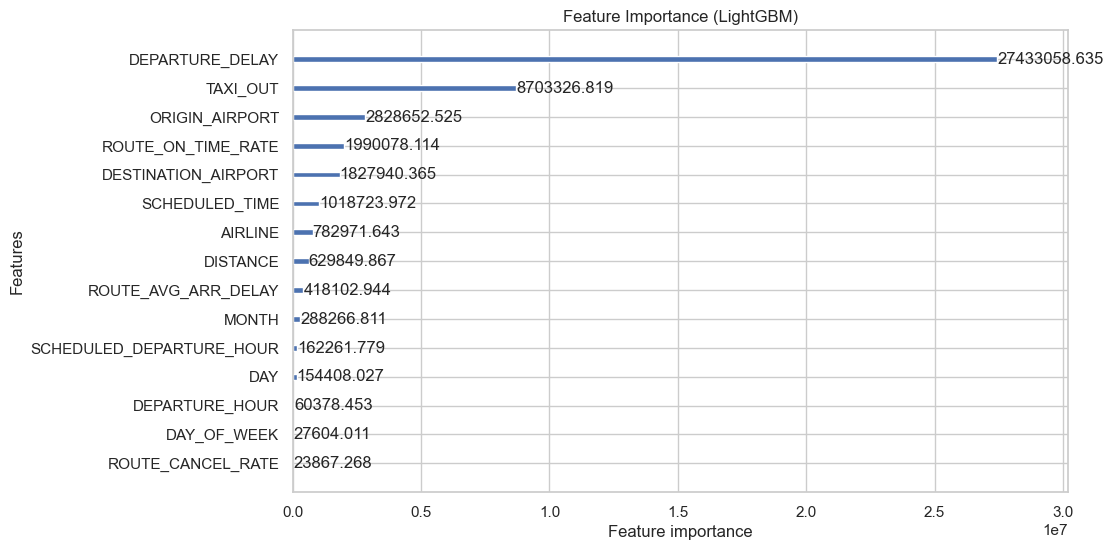


Feature Importance Ordenado pelo método 'Gain'
                     feature  importance_gain
5            DEPARTURE_DELAY     2.743306e+07
6                   TAXI_OUT     8.703327e+06
3             ORIGIN_AIRPORT     2.828653e+06
15        ROUTE_ON_TIME_RATE     1.990078e+06
4        DESTINATION_AIRPORT     1.827940e+06
7             SCHEDULED_TIME     1.018724e+06
9                    AIRLINE     7.829716e+05
8                   DISTANCE     6.298499e+05
12       ROUTE_AVG_ARR_DELAY     4.181029e+05
0                      MONTH     2.882668e+05
10  SCHEDULED_DEPARTURE_HOUR     1.622618e+05
1                        DAY     1.544080e+05
11            DEPARTURE_HOUR     6.037845e+04
2                DAY_OF_WEEK     2.760401e+04
13         ROUTE_CANCEL_RATE     2.386727e+04
14         ROUTE_DIVERT_RATE     1.622965e+03
16       IS_REGIONAL_AIRPORT     4.087140e+01


In [ ]:
# Carrega modelo
model_path = Path('../modelos/model_lightgbm.txt')
if not 'model_lgb' in locals():
    if model_path.exists():
        model_lgb = lgb.Booster(model_file=model_path)
        print("Modelo 'model_lgb' carregado de disco local.")
    else:
        print("Modelo 'model_lgb'não existe no ambiente e não foi encontrado no disco local.")

if 'model_lgb' in locals():
    # Previsão (retorna probabilidades)
    y_pred_prob_lgb = model_lgb.predict(X_test)

    # Converter para binário (threshold default 0.5)
    y_pred_lgb = (y_pred_prob_lgb >= 0.5).astype(int)

    print("--- Relatório LightGBM ---")
    print(classification_report(y_test, y_pred_lgb))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob_lgb):.4f}")

    # Feature Importance Plot
    lgb.plot_importance(model_lgb, max_num_features=15, title='Feature Importance (LightGBM)', figsize=(10, 6), importance_type='gain')
    plt.show()

    # Tabela  de Feature importance
    feature_names = model_lgb.feature_name()

    # importance_type='split' é o padrão do gráfico (quantas vezes a feature foi usada)
    # importance_type='gain' é muitas vezes mais preciso (o quanto a feature reduziu o erro)
    importance_values_split = model_lgb.feature_importance(importance_type='split')
    importance_values_gain = model_lgb.feature_importance(importance_type='gain')

    df_importance = pd.DataFrame({
        'feature': feature_names,
        'importance_split': importance_values_split,
        'importance_gain': importance_values_gain
    })
    print("\nFeature Importance Ordenado pelo método 'Gain'")
    print(df_importance[['feature','importance_gain']].sort_values(by='importance_gain', ascending=False).head(20))
        

## 4. Modelo 2: CatBoost

O CatBoost geralmente lida melhor com categóricas sem precisar de muito ajuste.

In [17]:
%%time
print("--- Treinando CatBoost ---")

# CatBoost lida com NaNs e Categóricas nativamente
model_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    cat_features=cat_cols,
    auto_class_weights='Balanced', # Importante para o desbalanceamento
    verbose=100,
    task_type="CPU" # Mude para GPU se tiver disponível
)

model_cb.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

print("Treinamento CatBoost concluído.")

--- Treinando CatBoost ---
0:	test: 0.8940665	best: 0.8940665 (0)	total: 10.2s	remaining: 1h 25m 2s
100:	test: 0.9315221	best: 0.9315221 (100)	total: 8m 48s	remaining: 34m 46s
200:	test: 0.9354675	best: 0.9354675 (200)	total: 13m 58s	remaining: 20m 46s
300:	test: 0.9374376	best: 0.9374376 (300)	total: 17m 45s	remaining: 11m 44s
400:	test: 0.9387915	best: 0.9387915 (400)	total: 21m 49s	remaining: 5m 23s
499:	test: 0.9398067	best: 0.9398067 (499)	total: 25m 40s	remaining: 0us

bestTest = 0.9398066807
bestIteration = 499

Treinamento CatBoost concluído.
CPU times: user 1h 8min 1s, sys: 28min 18s, total: 1h 36min 19s
Wall time: 26min 2s


### 4.1 Avaliação do CatBoost

--- Relatório CatBoost ---
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92   1210741
         1.0       0.75      0.83      0.79    432130

    accuracy                           0.88   1642871
   macro avg       0.84      0.87      0.85   1642871
weighted avg       0.89      0.88      0.88   1642871

AUC-ROC: 0.9398


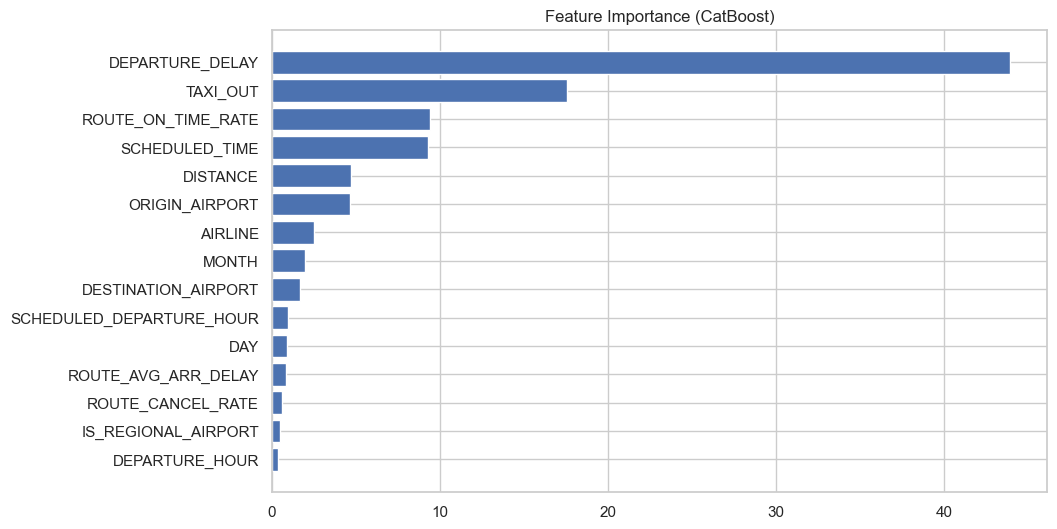

                     feature  importance
0             DEPARTURE_HOUR    0.364903
1        IS_REGIONAL_AIRPORT    0.445538
2          ROUTE_CANCEL_RATE    0.604333
3        ROUTE_AVG_ARR_DELAY    0.811232
4                        DAY    0.887324
5   SCHEDULED_DEPARTURE_HOUR    0.962313
6        DESTINATION_AIRPORT    1.665905
7                      MONTH    1.973578
8                    AIRLINE    2.506163
9             ORIGIN_AIRPORT    4.666777
10                  DISTANCE    4.671169
11            SCHEDULED_TIME    9.302809
12        ROUTE_ON_TIME_RATE    9.390466
13                  TAXI_OUT   17.566868
14           DEPARTURE_DELAY   43.920271


In [16]:
# Carrega modelo
model_path = Path('../modelos/model_catboost.cbm')
if not 'model_cb' in locals():
    if model_path.exists():
        model_cb = CatBoostClassifier()
        model_cb.load_model(model_path)
        print("Modelo 'model_cb' carregado de disco local.")
    else:
        print("Modelo 'model_cb'não existe no ambiente e não foi encontrado no disco local.")


y_pred_prob_cb = model_cb.predict_proba(X_test)[:, 1]
y_pred_cb = model_cb.predict(X_test)

print("--- Relatório CatBoost ---")
print(classification_report(y_test, y_pred_cb))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob_cb):.4f}")

# Feature Importance
feature_importance = model_cb.get_feature_importance()
sorted_idx = np.argsort(feature_importance)[-15:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance (CatBoost)')
plt.show()

feature_importance_df_catboost = pd.DataFrame({
    'feature': np.array(X_test.columns)[sorted_idx],
    'importance': feature_importance[sorted_idx]
})


print(feature_importance_df_catboost)

## 5. Comparativo Final (Curva ROC)

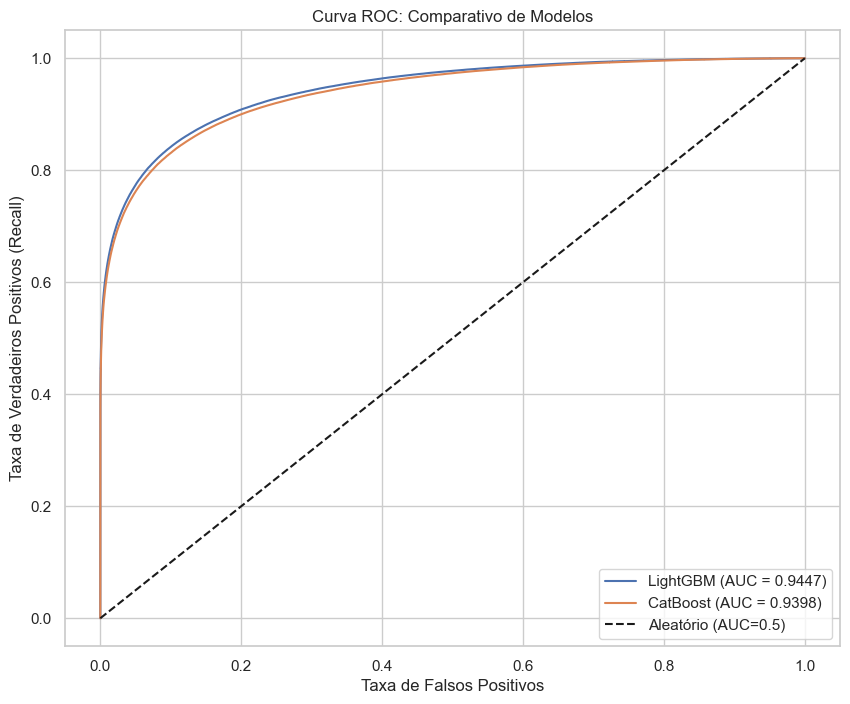

In [19]:
plt.figure(figsize=(10, 8))

# LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_prob_lgb)
auc_lgb = roc_auc_score(y_test, y_pred_prob_lgb)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.4f})')

# CatBoost
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_pred_prob_cb)
auc_cb = roc_auc_score(y_test, y_pred_prob_cb)
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC=0.5)')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC: Comparativo de Modelos')
plt.legend()
plt.show()

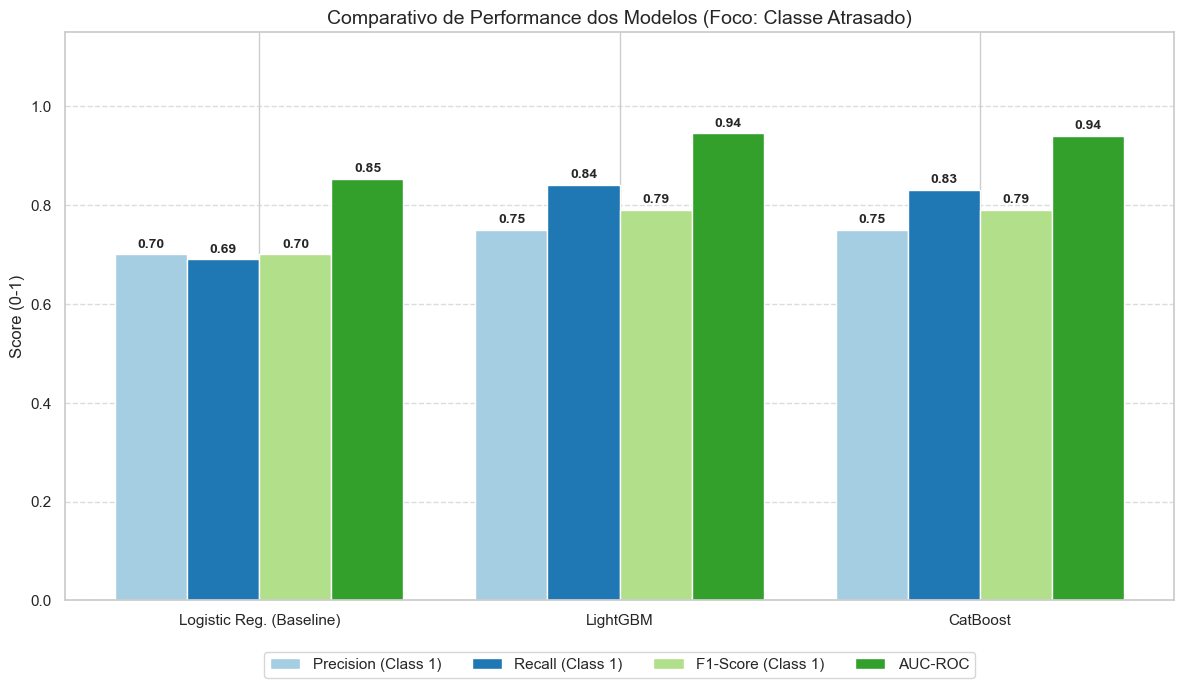

In [3]:
# Dados extraídos dos relatórios de classificação
models = ['Logistic Reg. (Baseline)', 'LightGBM', 'CatBoost']
precision = [0.7, 0.75, 0.75]
recall = [0.69, 0.84, 0.83]
f1 = [0.7, 0.79, 0.79]
auc = [0.8529, 0.9447, 0.9398]

x = np.arange(len(models))  # Localização dos rótulos
width = 0.2  # Largura das barras

fig, ax = plt.subplots(figsize=(12, 7))

# Criando as barras para cada métrica
rects1 = ax.bar(x - width*1.5, precision, width, label='Precision (Class 1)', color='#a6cee3')
rects2 = ax.bar(x - width/2, recall, width, label='Recall (Class 1)', color='#1f78b4')
rects3 = ax.bar(x + width/2, f1, width, label='F1-Score (Class 1)', color='#b2df8a')
rects4 = ax.bar(x + width*1.5, auc, width, label='AUC-ROC', color='#33a02c')

# Adicionando textos, títulos e rótulos
ax.set_ylabel('Score (0-1)')
ax.set_title('Comparativo de Performance dos Modelos (Foco: Classe Atrasado)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.set_ylim(0, 1.15) # Espaço extra para a legenda
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Função para colocar os valores acima das barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 pontos de offset vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.show()


Nesta seção, consolidamos os resultados dos três modelos testados: o Baseline (Regressão Logística), o LightGBM e o CatBoost. O objetivo principal é identificar qual modelo oferece o melhor equilíbrio para a nossa regra de negócio: **minimizar o risco de passageiros perderem conexões** (o que exige um alto *Recall*).

### 1. Resumo Executivo: O Vencedor

🏆 **Modelo Vencedor: LightGBM**

O **LightGBM** apresentou o melhor desempenho global, superando ligeiramente o CatBoost e drasticamente o Baseline em métricas críticas.
* **Melhor Recall (84%):** Captura a grande maioria dos atrasos reais, sendo vital para a gestão proativa de conexões.
* **Melhor AUC (0.9447):** Demonstra a maior capacidade de discriminação entre voos pontuais e atrasados.
* **Velocidade:** Treinamento eficiente e importância de features coerente com a realidade operacional.

---

### 2. Comparativo Detalhado de Métricas

A tabela abaixo compara o desempenho na classe positiva (`1` = Atraso $\ge$ 5min), que é o nosso foco.

| Métrica | Regressão Logística (Baseline) | LightGBM | CatBoost | Análise |
| :--- | :---: | :---: | :---: | :--- |
| **Recall (Sensibilidade)** | 0.50 | **0.84** | 0.83 | **Ponto Crítico.** O Baseline falha em detectar metade dos atrasos. Os modelos de Boosting recuperam quase 35% a mais de atrasos reais. |
| **Precision** | **0.92** | 0.75 | 0.75 | O Baseline é "conservador": só avisa quando tem certeza absoluta (atraso na partida muito alto). Os modelos de Boosting aceitam mais falsos positivos para garantir que não perdem atrasos. |
| **F1-Score** | 0.64 | **0.79** | **0.79** | O equilíbrio entre precisão e recall é muito superior nos modelos avançados. |
| **AUC-ROC** | 0.8529 | **0.9447** | 0.9398 | Indica que o LightGBM é o mais robusto em diferentes limiares de decisão. |

---

### 3. Análise Individual dos Modelos

#### A. Regressão Logística (Baseline)
* **Comportamento:** Atua como um "espelho" do `DEPARTURE_DELAY`.
* **Limitação:** Como vimos na análise de probabilidade, ele precisa de um atraso na partida de quase 17-20 minutos para ter certeza do atraso na chegada.
* **Problema:** Ele ignora voos que saíram com 5-10 minutos de atraso mas que *vão* atrasar na chegada devido a problemas de táxi ou rota. Por isso, o **Recall é de apenas 50%**.

#### B. LightGBM (Campeão)
* **Ponto Forte:** Conseguiu extrair valor das variáveis complexas (`TAXI_OUT`, `ROUTE_STATS`) para prever atrasos que o Baseline perdeu.
* **Feature Importance (Gain):**
    1.  **`DEPARTURE_DELAY`**: Dominante absoluto. Confirma que o atraso na partida é o principal causador.
    2.  **`TAXI_OUT`**: A segunda variável mais importante. Mostra que o tempo de solo é um gargalo crucial que define se o voo recupera ou atrasa mais.
    3.  **`ORIGIN_AIRPORT` / `ROUTE_*`**: Atuam como fatores de ajuste fino.

#### C. CatBoost (Vice-Campeão)
* **Desempenho:** Virtualmente idêntico ao LightGBM, com uma diferença marginal de 0.005 no AUC e 1% no Recall.
* **Diferencial:** A lista de importância de features coloca um peso enorme em `TAXI_OUT` (17%) e `SCHEDULED_TIME` (9%), mostrando que ele encontrou padrões similares de forma independente.
* **Conclusão:** É uma alternativa sólida, mas como o LightGBM treinou bem e teve métricas ligeiramente superiores, não há motivo forte para preferi-lo neste cenário específico.

---

### 4. Conclusão de Negócio

Para a aplicação de **Gestão Proativa de Conexões**, é recomendado seguir com o **LightGBM**.

1.  **Segurança Operacional:** Com 84% de Recall, a equipe de solo será alertada sobre a vasta maioria dos voos problemáticos com 30 minutos de antecedência.
2.  **Custo de Falso Positivo:** A Precisão de 75% significa que 1 em cada 4 alertas será "falso" (o voo acaba chegando no horário). Operacionalmente, isso é aceitável: é melhor preparar a equipe para uma conexão rápida que não foi necessária, do que deixar um passageiro perder o voo por falta de aviso (o erro do Baseline).

## 6. Análise dos Erros do Modelo Vencedor

--- Preparando Análise de Erros ---
Contagem por Tipo de Resultado:
result_type
TN (Acerto Pontual)    1092051
TP (Acerto Atraso)      362886
FP (Alarme Falso)       118690
FN (Perdeu Atraso)       69244
Name: count, dtype: int64


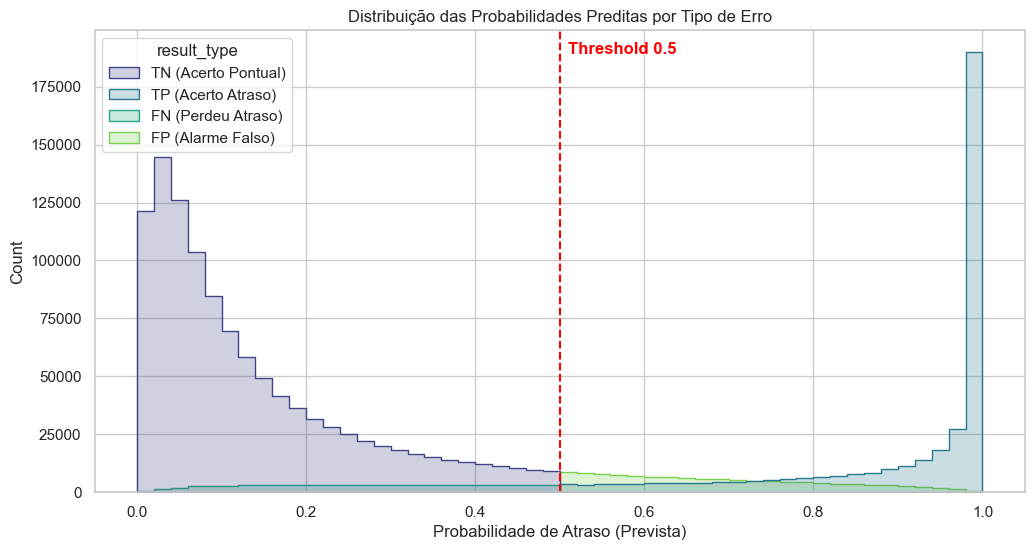

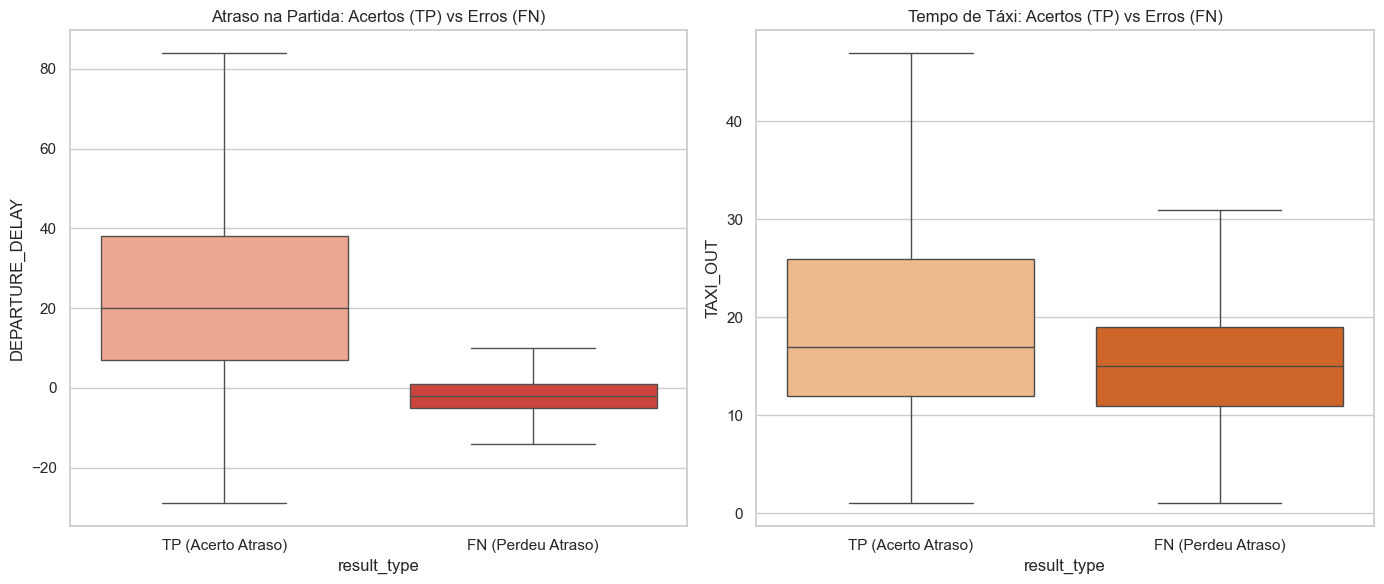

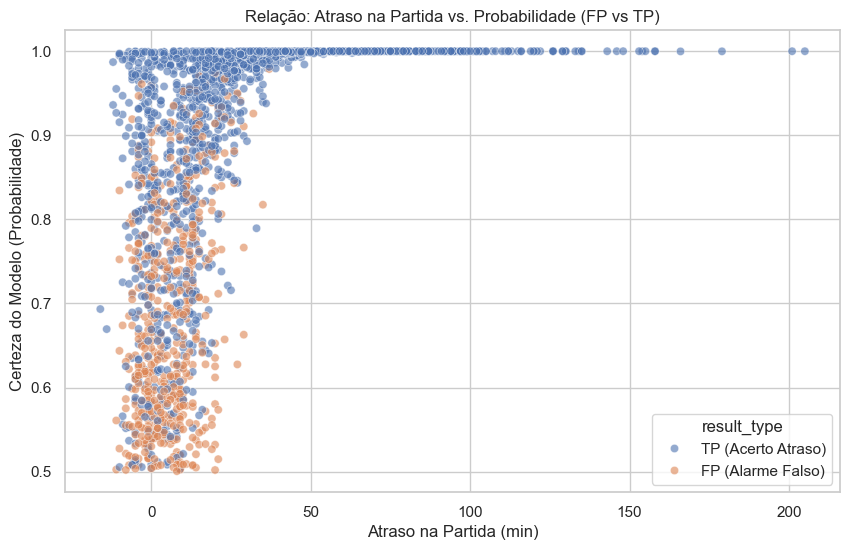


--- Top 5 Falsos Negativos (O modelo tinha certeza que era pontual, mas atrasou muito) ---
        AIRLINE ORIGIN_AIRPORT  DEPARTURE_DELAY  TAXI_OUT  DISTANCE    y_prob  \
3759391      MQ            ORD             -2.0      17.0       122  0.000788   
4508020      AA          13930            -10.0      11.0       606  0.001641   
1970875      MQ            ORD             -3.0      18.0       147  0.001705   
3488273      OO            ORD             -5.0      12.0        67  0.002221   
3207600      MQ            ORD             -1.0       7.0       139  0.002270   

                result_type  
3759391  FN (Perdeu Atraso)  
4508020  FN (Perdeu Atraso)  
1970875  FN (Perdeu Atraso)  
3488273  FN (Perdeu Atraso)  
3207600  FN (Perdeu Atraso)  

--- Top 5 Falsos Positivos (O modelo tinha certeza que ia atrasar, mas chegou no horário) ---
        AIRLINE ORIGIN_AIRPORT  DEPARTURE_DELAY  TAXI_OUT  DISTANCE    y_prob  \
1582980      UA            EWR             69.0      10.0      22

In [21]:
# --- 1. Preparar o DataFrame de Análise de Erros ---
print("--- Preparando Análise de Erros ---")

# Cria um DF com as features de teste, o alvo real e a probabilidade prevista
# (Usamos .copy() para não alterar o original)
df_error = X_test.copy()
df_error['y_true'] = y_test
df_error['y_prob'] = model_lgb.predict(X_test)
df_error['y_pred'] = (df_error['y_prob'] >= 0.5).astype(int)

# Define o Tipo de Erro
conditions = [
    (df_error['y_true'] == 1) & (df_error['y_pred'] == 1), # True Positive
    (df_error['y_true'] == 0) & (df_error['y_pred'] == 0), # True Negative
    (df_error['y_true'] == 0) & (df_error['y_pred'] == 1), # False Positive (Alarme Falso)
    (df_error['y_true'] == 1) & (df_error['y_pred'] == 0)  # False Negative (Perdemos o atraso!)
]
choices = ['TP (Acerto Atraso)', 'TN (Acerto Pontual)', 'FP (Alarme Falso)', 'FN (Perdeu Atraso)']
df_error['result_type'] = np.select(conditions, choices, default='Error')

print("Contagem por Tipo de Resultado:")
print(df_error['result_type'].value_counts())

# --- 2. Visualização: Onde estão os erros na distribuição de probabilidade? ---
plt.figure(figsize=(12, 6))
sns.histplot(data=df_error, x='y_prob', hue='result_type', element="step", bins=50, palette='viridis')
plt.axvline(0.5, color='red', linestyle='--')
plt.text(x=0.51, y=0.95, s='Threshold 0.5', color='red', 
         transform=plt.gca().get_xaxis_transform(), 
         fontweight='bold')

plt.title('Distribuição das Probabilidades Preditas por Tipo de Erro')
plt.xlabel('Probabilidade de Atraso (Prevista)')
plt.show()

# Insight: Os erros estão concentrados perto de 0.5 (dúvida) ou são erros confiantes (perto de 0 ou 1)?

# --- 3. Investigando Falsos Negativos (FN) - Por que erramos? ---
# Hipótese: O voo saiu no horário (baixo Departure Delay), mas algo aconteceu depois (Taxi ou Rota).

plt.figure(figsize=(14, 6))

# Plot A: Departure Delay nos FNs vs TPs
plt.subplot(1, 2, 1)
sns.boxplot(data=df_error[df_error['y_true'] == 1], x='result_type', y='DEPARTURE_DELAY', showfliers=False, palette='Reds')
plt.title('Atraso na Partida: Acertos (TP) vs Erros (FN)')
# Se o boxplot dos FNs for baixo, confirma que perdemos atrasos que ocorreram DEPOIS da partida.

# Plot B: Taxi Out nos FNs vs TPs
plt.subplot(1, 2, 2)
sns.boxplot(data=df_error[df_error['y_true'] == 1], x='result_type', y='TAXI_OUT', showfliers=False, palette='Oranges')
plt.title('Tempo de Táxi: Acertos (TP) vs Erros (FN)')
# Se o Taxi Out for alto nos FNs, o modelo subestimou o impacto do táxi.

plt.tight_layout()
plt.show()


# --- 4. Investigando Falsos Positivos (FP) - Por que o alarme falso? ---
# Hipótese: O voo saiu atrasado, mas o piloto "pisou fundo" (Scheduled Time alto vs Real).

# Vamos calcular a "Folga" (Buffer) que o voo tinha
# Não temos AIR_TIME aqui (seria vazamento), mas podemos ver a Distância e Scheduled Time.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_error[df_error['result_type'].isin(['FP (Alarme Falso)', 'TP (Acerto Atraso)'])].sample(2000), 
                x='DEPARTURE_DELAY', y='y_prob', hue='result_type', alpha=0.6)
plt.title('Relação: Atraso na Partida vs. Probabilidade (FP vs TP)')
plt.xlabel('Atraso na Partida (min)')
plt.ylabel('Certeza do Modelo (Probabilidade)')
plt.show()

# --- 5. Os "Piores" Erros (Top Misses) ---
print("\n--- Top 5 Falsos Negativos (O modelo tinha certeza que era pontual, mas atrasou muito) ---")
# Ordena por menor probabilidade, mas era atraso (y_true=1)
cols_show = ['AIRLINE', 'ORIGIN_AIRPORT', 'DEPARTURE_DELAY', 'TAXI_OUT', 'DISTANCE', 'y_prob', 'result_type']
print(df_error[df_error['result_type'] == 'FN (Perdeu Atraso)'].sort_values(by='y_prob').head(5)[cols_show])

print("\n--- Top 5 Falsos Positivos (O modelo tinha certeza que ia atrasar, mas chegou no horário) ---")
# Ordena por maior probabilidade, mas foi pontual (y_true=0)
print(df_error[df_error['result_type'] == 'FP (Alarme Falso)'].sort_values(by='y_prob', ascending=False).head(5)[cols_show])

## 7. Salva os Modelos

In [21]:
# --- 1. Salvar o Modelo LightGBM ---
if 'model_lgb' in locals():
    # O método .save_model() salva a estrutura da árvore em um arquivo de texto.
    # É leve e pode ser lido até humanamente se necessário.
    filename_lgb = '../modelos/model_lightgbm.txt'
    model_lgb.save_model(filename_lgb)
    print(f"✅ Modelo LightGBM salvo com sucesso como: {filename_lgb}")
else:
    print("⚠️ Modelo LightGBM não encontrado na memória.")

# --- 2. Salvar o Modelo CatBoost ---
if 'model_cb' in locals():
    # O CatBoost tem seu próprio formato binário (.cbm) que é altamente otimizado.
    filename_cb = '../modelos/model_catboost.cbm'
    
    # O parâmetro format="cbm" garante o formato binário nativo
    model_cb.save_model(filename_cb, format="cbm")
    print(f"✅ Modelo CatBoost salvo com sucesso como: {filename_cb}")
else:
    print("⚠️ Modelo CatBoost não encontrado na memória.")

print("\n--- Instruções para Carregar Futuramente ---")
print("# Para carregar o LightGBM:")
print(f"novo_modelo_lgb = lgb.Booster(model_file='{filename_lgb}')")
print("\n# Para carregar o CatBoost:")
print("novo_modelo_cb = CatBoostClassifier()")
print(f"novo_modelo_cb.load_model('{filename_cb}')")

✅ Modelo LightGBM salvo com sucesso como: ../modelos/model_lightgbm.txt
✅ Modelo CatBoost salvo com sucesso como: ../modelos/model_catboost.cbm

--- Instruções para Carregar Futuramente ---
# Para carregar o LightGBM:
novo_modelo_lgb = lgb.Booster(model_file='../modelos/model_lightgbm.txt')

# Para carregar o CatBoost:
novo_modelo_cb = CatBoostClassifier()
novo_modelo_cb.load_model('../modelos/model_catboost.cbm')
